## Demonstration of applicability of PaleoSTeHM to non-sea level paleoclimate datasets

Roger Creel - roger.creel@whoi.edu


In this notebook, we will use the PaleoSTeHM temporal Gaussian Process (GP) framework to fit proxy data for ocean mean temperature from [Shackleton et al. (2021)](https://cp.copernicus.org/articles/17/2273/2021/cp-17-2273-2021.pdf). Our goal is to reproduce the results from [Creel et al. 2024](https://eartharxiv.org/repository/view/5419/), who used the [PyMC](https://www.pymc.io/welcome.html) library. 


In [14]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import pymc as pm
from scipy.spatial.distance import pdist
import xarray as xr


import sys
sys.path.append('../../')
import PSTHM 
import time
from scipy import interpolate
pyro.set_rng_seed(0) #set random seed used in this notebook

SEED = 2021
rng = np.random.default_rng(SEED)

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20,
       'family':'Helvetica'}
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['legend.frameon'] = 'False'

matplotlib.rc('font',**font)
import warnings
warnings.filterwarnings("ignore")

# Load mean ocean temperature 

We first load the mean ocean temperature anomaly from Shackleton et al. (2021). 

(25.0, 0.0)

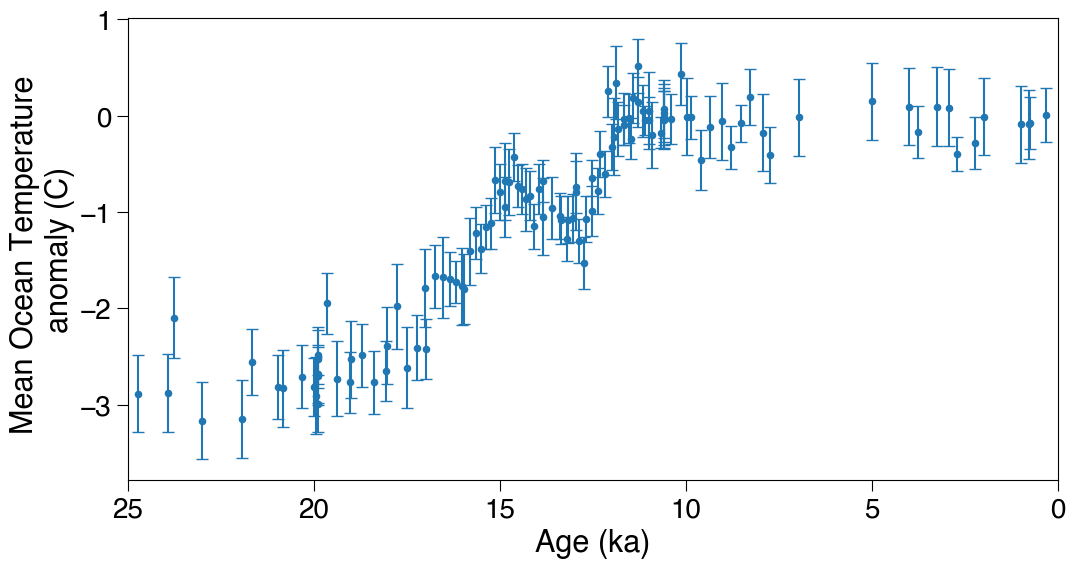

In [2]:
p = 'IFILES/MOT_T1_compiled_w_spline.csv'
df_s = pd.read_csv(p, header=9).dropna(how='any').iloc[:,:6]
df_s.plot.scatter(x='Age', y='MOT_anomaly')
plt.errorbar(df_s.Age, df_s.MOT_anomaly, yerr=df_s.Error, ls='none', capsize=4, )
plt.ylabel('Mean Ocean Temperature \nanomaly (C)')
plt.xlabel('Age (ka)')
plt.xlim(25, 0)

# Compute Mean ocean thermal expansion (Wunsch et al. 2004)

We then convert mean ocean temperature to mean ocean thermal expansion assuming the ocean is fully mixed in temperature and salinity such that pure temp change gives rise to a "thermosteric" height change of:

$h_T$ = $\alpha \Delta T h_o$

(25.0, 0.0)

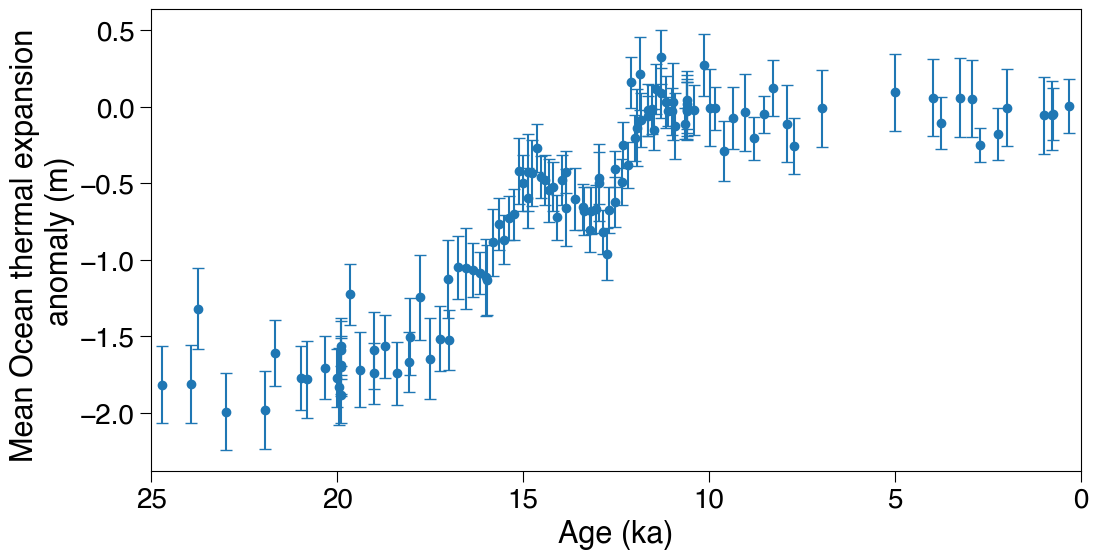

In [3]:
def calc_ht(delT, h_o=3700):
    
    # h_o is mean depth of the ocean to be heated, unit=meters
    α = 1.7e-4 #units of 1/K
    
    h_t = α * h_o * delT
        
    return h_t

df_s['tsl_mean'] = calc_ht(df_s['MOT_anomaly'])
df_s['tsl_std'] = calc_ht(df_s['Error'])

plt.scatter(x=df_s['Age'], y=df_s['tsl_mean'])
plt.errorbar(df_s['Age'], df_s['tsl_mean'], yerr=df_s.tsl_std, ls='none',  capsize=4, )
plt.ylabel('Mean Ocean thermal expansion \nanomaly (m)')
plt.xlabel('Age (ka)')
plt.xlim(25, 0)

# Produce model with PyMC (Creel et al. 2024)
We next produce the model from Creel et al. 2024, which used PyMC to fit the thermosteric sea level proxy data. We first define a few helper functions:

In [5]:

def get_ℓ_prior(points):
    """Calculates mean and sd for InverseGamma prior on lengthscale"""
    distances = pdist(points[:, None])
    distinct = distances != 0
    ℓ_l = distances[distinct].min() if sum(distinct) > 0 else 0.1
    ℓ_u = distances[distinct].max() if sum(distinct) > 0 else 1
    ℓ_σ = max(0.1, (ℓ_u - ℓ_l) / 6)
    ℓ_μ = ℓ_l + 3 * ℓ_σ
    return ℓ_μ, ℓ_σ


ℓ_μ, ℓ_σ = [stat for stat in get_ℓ_prior(X_)]

def get_quantiles(samples, quantiles=[5, 50, 95]):
    return [np.percentile(samples, p, axis=1) for p in quantiles]


def plot_mean(ax, mean_samples):
    """Plots the median and 95% CI from samples of the mean

    Note that, although each individual GP exhibits a normal distribution at each point
    (by definition), we are sampling from a mixture of GPs defined by the posteriors of
    our hyperparameters. As such, we use percentiles rather than mean +/- stdev to
    represent the spread of predictions from our models.
    """
    l, m, u = get_quantiles(mean_samples)
    ax.plot(Xnew, m, "C0", label="Median", zorder=4)
    ax.fill_between(Xnew_, l, u, facecolor="C0", alpha=0.3, label="90% credible interval", zorder=3)

    # ax.plot(Xnew, ynew, "--k", label="Mean Function")
    ax.plot(X, y, "C1.", label='Shackleton et al. 2021')
    # ax.set_title("Mean Behavior")
    ax.legend(loc="lower right")

Then we build a PyMC model: 

In [6]:
X = df_s.Age.values.reshape(-1,1)
X_ = X.flatten()
y =  calc_ht(df_s.MOT_anomaly.values)
y_err = calc_ht(df_s.Error.values)

Xnew = np.linspace(df_s.Age.min(), df_s.Age.max(), 200)[:, None]
Xnew_ = Xnew.flatten()

X_obs = X
X_obs_ = X_
y_obs = y[:,None].T
y_obs_ = y


st = time.time() 

with pm.Model() as model_hm:
    ℓ = pm.InverseGamma("ℓ", mu=ℓ_μ, sigma=ℓ_σ)
    η = pm.Gamma("η", alpha=2, beta=1)
    cov = η**2 * pm.gp.cov.Matern32(input_dim=1, ls=ℓ)

    gp_hm = pm.gp.Marginal(cov_func=cov)

    σ = pm.Exponential("σ", lam=1)

    ml_hm = gp_hm.marginal_likelihood("ml_hm", X=X_obs, y=y_obs_, noise=σ)

    trace_hm = pm.sample(return_inferencedata=True, random_seed=SEED, cores=1) # , chains=4) #, mp_ctx="spawn")

with model_hm:
    mu_pred_hm = gp_hm.conditional("mu_pred_hm", Xnew=Xnew)
    noisy_pred_hm = gp_hm.conditional("noisy_pred_hm", Xnew=Xnew, pred_noise=False)

    # adding duplicate to fix dimension sampling issue
    noisy_pred_hm_2 = gp_hm.conditional("noisy_pred_hm_2", Xnew=Xnew, pred_noise=False)

    samples_hm = pm.sample_posterior_predictive(trace_hm, var_names=["mu_pred_hm", "noisy_pred_hm", "noisy_pred_hm_2"])

et = time.time() # get the end time

# get the execution time
elapsed_time_pymc = et - st
print('Execution time: {:3.3f} s'.format(elapsed_time_pymc))

# Sample from posterior and get quantiles
mu_samples = samples_hm.posterior_predictive["mu_pred_hm"].stack(samples=['chain', 'draw'])
l, m, u = get_quantiles(mu_samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ℓ, η, σ]


Output()

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [mu_pred_hm, noisy_pred_hm, noisy_pred_hm_2]


Output()

Execution time: 214.603 s


# Fit PaleoSTeHM Gaussian Process Regression to thermosteric sea level change data

We next use PaleoSTeHM to fit a Gaussian Process regression model to the sme data.  We'll use a Matern 5/2 kernel, which assumes that the underlying process that produced the data is twice differentiable. 

  0%|          | 0/500 [00:00<?, ?it/s]

Likelihood 56.900
Execution time: 4.02 s
PaleoSTeHM was 210.58 seconds faster than PyMC


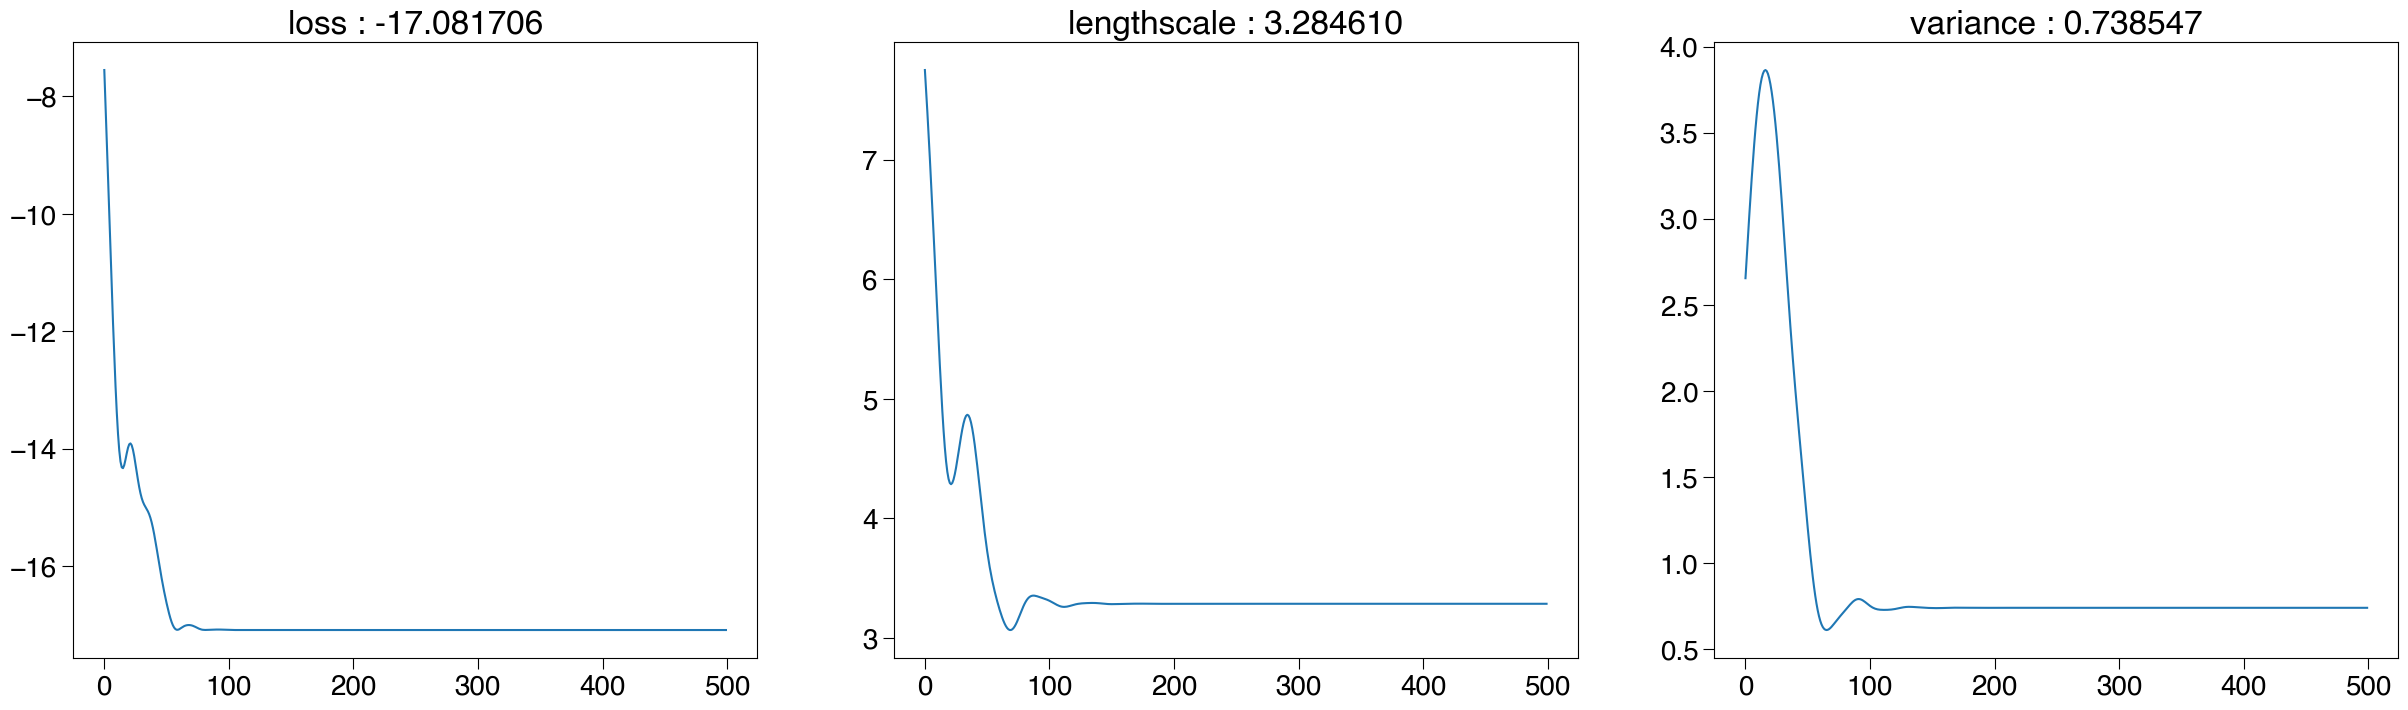

In [7]:
# calculate computational time
import pyro.contrib.gp as gp

st = time.time() 

pyro.clear_param_store()

X = torch.tensor(df_s.Age).flatten() * -1
y = torch.tensor(df_s.tsl_mean).flatten()
x_sigma = torch.tensor(df_s.tsl_std).flatten() * 0 
y_sigma = torch.tensor(df_s.tsl_std).flatten()

#generate kernels
Matern52_kernel = PSTHM.kernels.Matern52(
    input_dim=1,variance=torch.tensor(2),lengthscale=torch.tensor(3))
Matern52_kernel.set_prior("variance", dist.Uniform(torch.tensor(0.1), torch.tensor(5.)))
Matern52_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.), torch.tensor(10.)))

gpr = PSTHM.model.GPRegression_V(X, y, Matern52_kernel,noise=torch.tensor(y_sigma**2),jitter=1e-5)

#Empirical bayes optimization for noisy-input GP, we need to provide x_sigma here
gpr,track_list = PSTHM.opti.SVI_NI_optm(gpr,x_sigma,num_iteration=500)

#calulate log likelihood of the model prediction
pred_y,_ = gpr(X.double(), full_cov=True)

fit_likelihood = PSTHM.post.cal_likelihood(y.detach().numpy(),y_sigma.detach().numpy(),pred_y.detach().numpy())
print('Likelihood {:3.3f}'.format(fit_likelihood))
axes = PSTHM.plotting.plot_track_list(track_list)

et = time.time() # get the end time

# get the execution time
elapsed_time = et - st
time_diff = elapsed_time_pymc - elapsed_time
print('Execution time: {:3.2f} s'.format( elapsed_time))
print('PaleoSTeHM was {:3.2f} seconds faster than PyMC'.format( time_diff))


# Visualize GP posterior

We then visualize the posterior along with the underlying data: 

<ErrorbarContainer object of 3 artists>

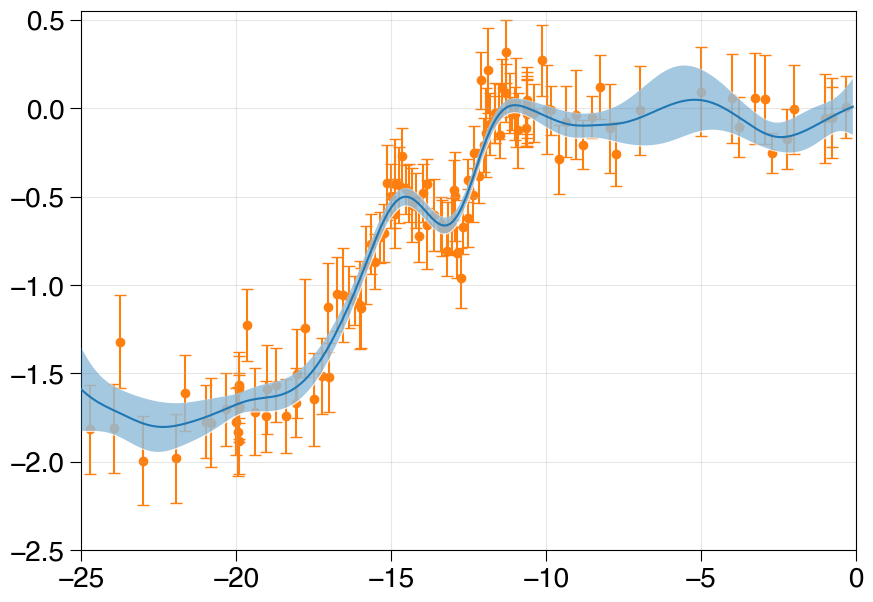

In [8]:
x_test = torch.arange(-25,0, 0.1,requires_grad=True).double()
c_kernel_y_mean, c_kernel_y_var = gpr(x_test, full_cov=True)

x_out = x_test.detach().numpy()
y_out = c_kernel_y_mean.detach().numpy()

y_out_std = torch.diag(c_kernel_y_var).sqrt().detach().numpy() 


######## PLOT PaleoSTeHM ##########
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(x_out, y_out, zorder=3)
ax.fill_between(x_out,  y_out -  y_out_std, y_out +  y_out_std, alpha=0.4, zorder=3, label='PaleoSTeHM temporal model')
ax.fill_between(x_out,  y_out -  y_out_std, y_out +  y_out_std, color='w', alpha=0.7, zorder=1)

# ds_tsl.mu.plot()

ax.set_xlim(-25, 0)
ax.set_ylim(-2.5, 0.55)
ax.grid(alpha=0.3)

ax.scatter(x=X, y=y, zorder=0)
ax.errorbar(X, y, yerr=y_sigma, ls='none',  capsize=4, zorder=0)

# Visualize difference between PaleoSTeHM and Creel et al. 2024 posteriors

Finally, we show how different the to models are to demonstrate the difference. 

In [48]:
m_out# .interp(age=x_out)

<xarray.DataArray (age: 200)>
array([-0.02150134, -0.03030641, -0.03715159, -0.04296658, -0.04673472,
       -0.05309671, -0.05946974, -0.06388626, -0.06936063, -0.07668301,
       -0.08039106, -0.08392289, -0.08643186, -0.08972933, -0.0928343 ,
       -0.09388252, -0.09360835, -0.09203519, -0.08886354, -0.0822132 ,
       -0.0717293 , -0.06275575, -0.05343251, -0.04226551, -0.03333535,
       -0.02511965, -0.01725279, -0.0108449 , -0.0028889 ,  0.00353462,
        0.01278322,  0.0217458 ,  0.0276301 ,  0.03289468,  0.03942488,
        0.04378952,  0.04695663,  0.04958951,  0.05150893,  0.0513807 ,
        0.05026399,  0.04903133,  0.04571355,  0.04078453,  0.03387164,
        0.02738848,  0.01919964,  0.01089043,  0.00204521, -0.00867549,
       -0.01641394, -0.0261171 , -0.03335591, -0.04003296, -0.04943854,
       -0.05679506, -0.06586116, -0.07425449, -0.08117778, -0.0884295 ,
       -0.09286885, -0.09231418, -0.0903968 , -0.08698284, -0.08580126,
       -0.08406905, -0.08360725, -0.08335552, -0.08532698, -0.08596279,
       -0.08620186, -0.08414745, -0.08263239, -0.07949719, -0.07326068,
       -0.06409545, -0.05310958, -0.0421381 , -0.02755458, -0.01461838,
       -0.00475376,  0.00229627,  0.00769306,  0.01018035,  0.01414059,
        0.01742089,  0.02136985,  0.0248796 ,  0.02583654,  0.02198077,
        0.01311462, -0.00554355, -0.03068877, -0.06622611, -0.11206741,
       -0.16652135, -0.22819954, -0.29605972, -0.36504899, -0.432107  ,
       -0.49347929, -0.54613338, -0.58761591, -0.61644311, -0.63542729,
       -0.64456938, -0.64562839, -0.63889121, -0.62507685, -0.60712238,
       -0.58773498, -0.5676886 , -0.54863836, -0.53185631, -0.51678685,
       -0.50663513, -0.50089214, -0.50474942, -0.51849507, -0.5410347 ,
       -0.57291018, -0.61350796, -0.66103354, -0.71121519, -0.76467877,
       -0.81995711, -0.87467707, -0.92700951, -0.97682881, -1.02396739,
       -1.0666605 , -1.10888533, -1.1487169 , -1.18799104, -1.22957647,
       -1.27206365, -1.31335076, -1.3525736 , -1.38976613, -1.42233986,
       -1.45267974, -1.47957135, -1.50447339, -1.527647  , -1.54992162,
       -1.57174483, -1.58727186, -1.60193129, -1.61325001, -1.62223306,
       -1.62854544, -1.63288951, -1.6371506 , -1.63829138, -1.64108758,
       -1.64356161, -1.64550997, -1.65162809, -1.65952495, -1.66996314,
       -1.68141696, -1.69274803, -1.70549416, -1.71708229, -1.72758646,
       -1.73701914, -1.74697116, -1.756322  , -1.76535269, -1.77025091,
       -1.77685906, -1.78443616, -1.79010239, -1.79776713, -1.80655505,
       -1.81296223, -1.82269258, -1.82898912, -1.83325921, -1.83521048,
       -1.83531263, -1.83324636, -1.82769622, -1.82147879, -1.81084166,
       -1.79627455, -1.78191784, -1.76468554, -1.7460195 , -1.72963042,
       -1.71730599, -1.70829004, -1.70151439, -1.69661114, -1.6974477 ,
       -1.69943056, -1.70331945, -1.70829556, -1.7134396 , -1.71824779])
Coordinates:
  * age      (age) float64 0.32 0.4426 0.5652 0.6878 ... 24.35 24.47 24.6 24.72

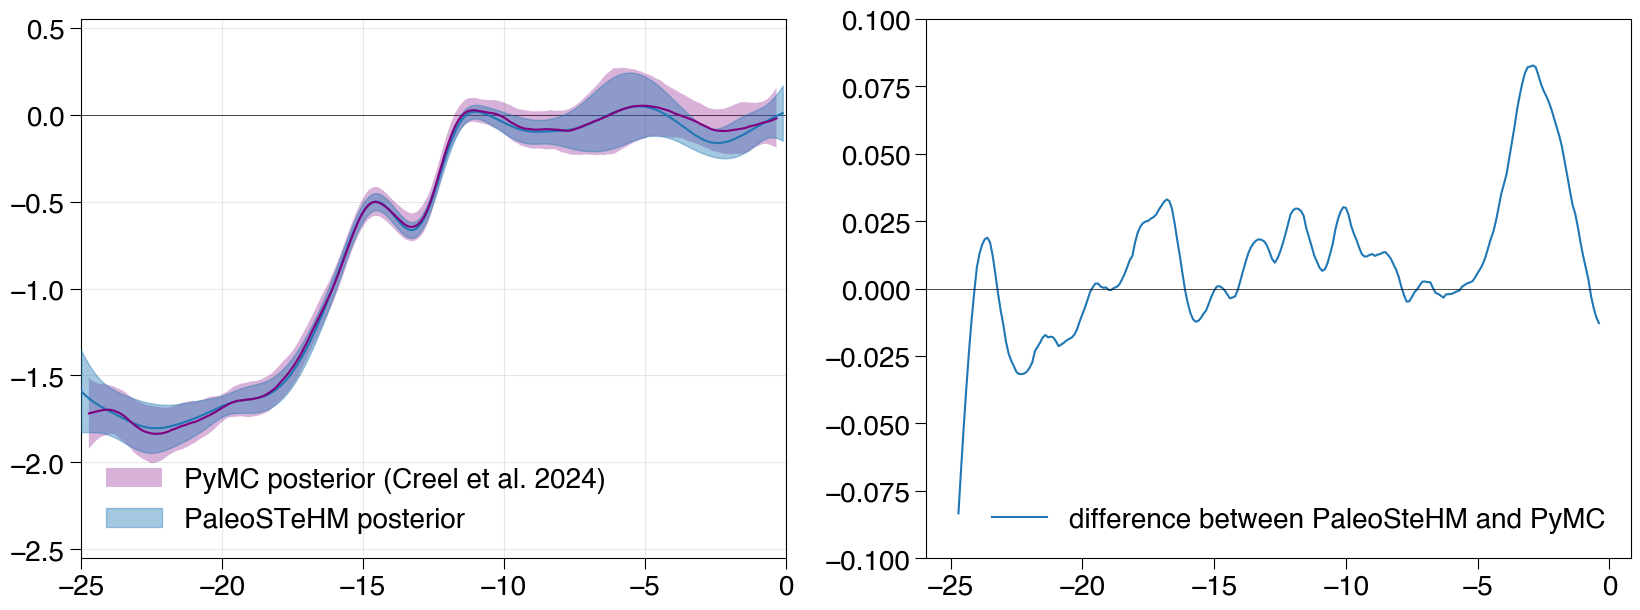

In [51]:
##### Get model difference on right age coordinates #### 
m_out = xr.DataArray(m, dims='age', coords={'age':Xnew[:,0] * -1})
diff = m_out.interp(age=x_out) - y_out


######## PLOT PaleoSTeHM ##########
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
ax, ax2 = axes.flatten()


ax.plot(Xnew * -1, m, "purple",  zorder=4)
ax.fill_between(Xnew_ * -1, l, u, facecolor="purple", label='PyMC posterior (Creel et al. 2024)', alpha=0.3, zorder=3)


ax.plot(x_out, y_out, zorder=3, color='C0')
ax.fill_between(x_out,  y_out -  y_out_std, y_out +  y_out_std, alpha=0.4, color='C0', zorder=3, label='PaleoSTeHM posterior')



ax.set_xlim(-25, 0)
ax.set_ylim(-2.55, 0.55)
ax.grid(alpha=0.3)

ax.legend()

ax2.plot(x_out, diff, label='difference between PaleoSteHM and PyMC')
# ax2.fill_between(x_out, -y_out_std, y_out_std, color='lightgray')

ax2.set_ylim(-0.1,  0.1)
[a.axhline(0, color='k', lw=0.5) for a in [ax, ax2]]
ax2.legend()


# Concluding comments

The large difference in time between PyMC and PaleoSTeHM is explained largely by the difference in statistical methods: We are using PyMC's Marginal Likelihood method, which is a classical GP implementation, while with PaleoSTeHM we are using a variational approximation of GP regression.  As you can see, the variational approximation is nearly 10x faster and achieves a vary similar result. Pretty cool! 

Feel free to reach out to me at <Roger.creel@gmail.com> if you have questions!